In [31]:
import cv2
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import quaternion
from utils import detectAirportRunway

faim_path = "/home/ackerman/Workspace/AirportRunwayDetection/data/EuRoc_FAIM_20240401/"

body_csv_path = faim_path + "state_groundtruth_estimate0/data.csv"
body_df = pd.read_csv(body_csv_path, sep=',')
display(body_df.head())

cam0_csv_path = faim_path + "cam0/data.csv"
cam0_df = pd.read_csv(cam0_csv_path, sep=",")
display(cam0_df.head())

img_dir = faim_path + "cam0/data_rgb/"

# sensor paras
sensor_yaml_path = faim_path + "cam0/sensor.yaml"
with open(sensor_yaml_path, 'r') as file:
    sensor = yaml.safe_load(file)
T_BS = sensor['T_BS']['data']
T_BS = np.array(T_BS).reshape(4,4)
R_BS = T_BS[0:3, 0:3]
t_BS = T_BS[3, 0:3]
K = sensor['intrinsics']
K = np.array([[K[0], 0, K[2]],
                               [0, K[1], K[3]],
                               [0, 0, 1]])
# print(K)

R_BS = np.array([[0, 1, 0],
                 [0, 0, 1],
                 [1, 0, 0]])

,#timestamp [ns],pos_x,pos_y,pos_z,quat_w,quat_x,quat_y,quat_z
0,1711643353566240768,-49.126205,-10.870415,-49.646474,0.994086,-0.000070,-0.000022,0.108597
1,1711643353569240832,-49.126205,-10.870415,-49.646474,0.994086,-0.000070,-0.000022,0.108597
2,1711643353572240896,-49.126205,-10.870415,-49.646474,0.994086,-0.000070,-0.000022,0.108597
3,1711643353575240960,-49.126205,-10.870415,-49.646474,0.994086,-0.000070,-0.000022,0.108597
4,1711643353578241024,-49.126161,-10.870405,-49.646474,0.994086,-0.000071,-0.000017,0.108597


,#timestamp [ns],filename
0,1711643353971249408,1711643353971249408.png
1,1711643354016250368,1711643354016250368.png
2,1711643354061251328,1711643354061251328.png
3,1711643354106252288,1711643354106252288.png
4,1711643354151253248,1711643354151253248.png


当前的位姿 P（位置）： [-49.12620521 -10.87041499 -49.64647412]
当前的位姿 R（旋转矩阵）：
[[ 9.76413381e-01 -2.15909486e-01 -5.92712287e-05]
 [ 2.15909492e-01  9.76413372e-01  1.34758077e-04]
 [ 2.87776731e-05 -1.44376810e-04  9.99999989e-01]]
点在body系下的坐标:
[[  45.45797504  -21.96926384   49.64199463]
 [1891.85567823 -430.25410199   49.52991274]
 [1901.57160539 -386.31550025   49.53597685]
 [  55.17390219   21.9693379    49.64805875]]
点在cam0系下的坐标:
[[ -21.96926384   49.64199463   45.45797504]
 [-430.25410199   49.52991274 1891.85567823]
 [-386.31550025   49.53597685 1901.57160539]
 [  21.9693379    49.64805875   55.17390219]]
内参
[[960   0 960]
 [  0 960 540]
 [  0   0   1]]
P_u:
[[ 496.04415358 1588.35982706]
 [ 741.67259656  565.13337395]
 [ 764.97033129  565.00801844]
 [1342.2561673  1403.85291788]]


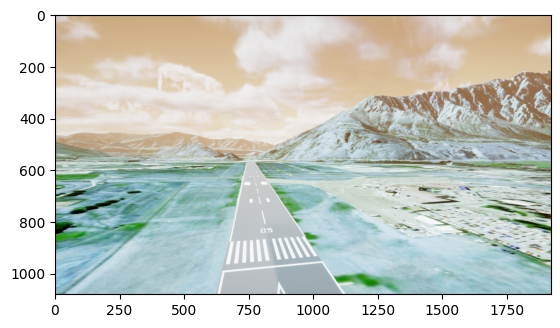

In [32]:
for _, row in cam0_df.head(1).iterrows():

    img_name = row['filename']
    img_path = img_dir + img_name
    img = cv2.imread(img_path)
    # plt.imshow(img)
    

for _, row in body_df.head(1).iterrows():
    
    # position of body frame
    p = np.array([row['pos_x'], row['pos_y'], row['pos_z']])
    # quaternion of body frame
    quat_data = np.quaternion(row['quat_w'], row['quat_x'], row['quat_y'], row['quat_z'])
    # rotation matrix of body frame
    R = quaternion.as_rotation_matrix(quat_data)
    
    # # 打印位置和旋转矩阵
    print("当前的位姿 P（位置）：", p)
    print("当前的位姿 R（旋转矩阵）：")
    print(R)

    # runway frame
    P_w = np.array([[0, -22.5, 0],
                  [1891, -22.5, 0],
                  [1891, 22.5, 0],
                  [0, 22.5, 0]])

    # 计算点在body系下的坐标
    P_b = np.dot(R.T, (P_w.T - p[:, None])).T

    print("点在body系下的坐标:")
    print(P_b)

    P_c = (R_BS @ P_b.T).T

    print("点在cam0系下的坐标:")
    print(P_c)

    print("内参")
    print(K)

    P_u = P_c @ K.T
    P_u = P_u[:, :2] / P_u[:, 2][:, None]

    print("P_u:")
    print(P_u)

    plt.imshow(img)
